<h1>Top 10 Classification - Modèle CNN</h1>
<br>

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [ ]:
!mkdir database
! mkdir database/ascii
! tar xzf drive/MyDrive/ocr/database/ascii.tgz -C database/ascii

! mkdir database/words
! tar xzf drive/MyDrive/ocr/database/words.tgz -C database/words

! mkdir database/images_test
! cp -r drive/MyDrive/ocr/database/images_test/* database/images_test/

! cp drive/MyDrive/ocr/src/streamlit/importation.py importation.py
! cp drive/MyDrive/ocr/src/streamlit/preprocessor_2.py preprocessor_2.py
! cp drive/MyDrive/ocr/src/streamlit/wsmodel.py wsmodel.py
! cp drive/MyDrive/ocr/src/streamlit/top10model.py top10model.py

! mkdir models
! cp drive/MyDrive/ocr/models/* models/

In [1]:
from  importation import Importation
from preprocessor import Preprocess
import top10model
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import cv2

In [ ]:
#import importlib
#import sys
#importlib.reload(sys.modules['preprocessor_2']) 

# Importation des données - preprocessing

In [2]:
imp = Importation('database')
df = imp.get_words().sample(frac=1, random_state=1).reset_index()

df.word_size = df.word_size.astype('float32')
print("Nombre d'enregistrements ", df.shape[0])


df = df[['file','label', 'word_size']]
df.info()
words_list = df[(df.word_size==3)|(df.word_size==4)].label.value_counts().head(10)
print("\nTop 10 mots 3 ou 4 lettres : \n")
print(words_list)

df = df[df.label.isin(words_list.index)]
encoder = LabelEncoder()
df["label_encoded"] = encoder.fit_transform(df.label)

df.head(20)

image_width = 128
image_height = 32
batch_size = 64
img_size = (image_width, image_height)
prepro = Preprocess(img_size, batch_size=batch_size, gaussianBlur=True)

df_train, df_valid, df_test = prepro.split_data(df, train_size=0.9)

x_train, y_train = df_train["file"].values, df_train["label_encoded"].values
x_test, y_test = df_test["file"].values, df_test["label_encoded"].values
x_valid, y_valid = df_valid["file"].values, df_valid["label_encoded"].values

train_ds = prepro.prepare_dataset_top10(x_train, y_train)
validation_ds = prepro.prepare_dataset_top10(x_valid, y_valid)
test_ds = prepro.prepare_dataset_top10(x_test, y_test)



Nombre d'enregistrements  96454
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96454 entries, 0 to 96453
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   file       96454 non-null  object 
 1   label      96454 non-null  object 
 2   word_size  96454 non-null  float32
dtypes: float32(1), object(2)
memory usage: 1.8+ MB

Top 10 mots 3 ou 4 lettres : 

the     4986
and     2110
was      970
that     968
for      718
had      670
with     645
his      597
The      548
not      412
Name: label, dtype: int64
initialisation


2022-09-19 10:28:02.919887: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-19 10:28:02.955205: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-19 10:28:02.955429: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-19 10:28:02.956143: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

# Chargement du modèle

In [5]:
#import importlib
#import sys
#importlib.reload(sys.modules['wsmodel']) 
image_width = 128
image_height = 32
num_classes = 10
train = False
#model = top10model.create_model_lenet(image_width, image_height, num_classes)
model = top10model.create_model_cnn(image_width, image_height, num_classes)
#model = top10model.create_model_dense(image_width, image_height, num_classes)
if train:
    opt = tf.keras.optimizers.Adam()
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
model.summary()

Model: "CNN_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 128, 32, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 124, 28, 32)       832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 14, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 62, 14, 32)        0         
                                                                 
 flatten (Flatten)           (None, 27776)             0         
                                                                 
 dense (Dense)               (None, 128)               3555456   
                                                         

# Entraînement du modèle 

Epoch 1/50


2022-09-19 10:29:22.957107: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8302


178/178 [==============================] - 40s 213ms/step - loss: 0.9911 - accuracy: 0.6854 - val_loss: 0.5741 - val_accuracy: 0.8558
Epoch 2/50
178/178 [==============================] - 1s 5ms/step - loss: 0.4352 - accuracy: 0.8736 - val_loss: 0.4208 - val_accuracy: 0.8732
Epoch 3/50
178/178 [==============================] - 1s 5ms/step - loss: 0.3004 - accuracy: 0.9122 - val_loss: 0.3504 - val_accuracy: 0.8970
Epoch 4/50
178/178 [==============================] - 1s 5ms/step - loss: 0.2233 - accuracy: 0.9353 - val_loss: 0.3271 - val_accuracy: 0.8986
Epoch 5/50
178/178 [==============================] - 1s 5ms/step - loss: 0.1681 - accuracy: 0.9520 - val_loss: 0.3772 - val_accuracy: 0.8780
Epoch 6/50
178/178 [==============================] - 1s 5ms/step - loss: 0.1450 - accuracy: 0.9583 - val_loss: 0.3192 - val_accuracy: 0.9097
Epoch 7/50
178/178 [==============================] - 1s 5ms/step - loss: 0.1146 - accuracy: 0.9678 - val_loss: 0.3457 - val_accuracy: 0.9113
Epoch 8/50
178

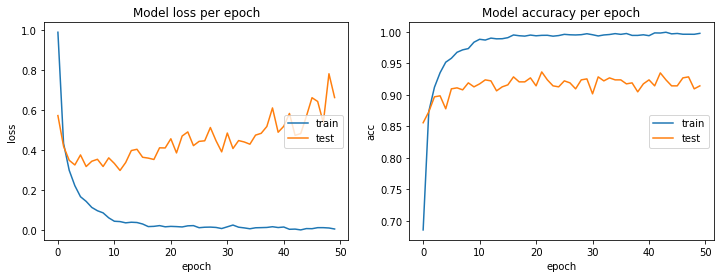

In [6]:
if train:
    epochs = 50
    training_history = model.fit(
        train_ds,
        validation_data=validation_ds,
        epochs=epochs,
        verbose=1
    )

    train_loss = training_history.history["loss"]
    val_loss = training_history.history["val_loss"]
    train_acc = training_history.history["accuracy"]
    val_acc = training_history.history["val_accuracy"]
    plt.figure(figsize=(12, 4))
    plt.subplot(121)
    plt.plot(train_loss)
    plt.plot(val_loss)
    plt.title('Model loss per epoch')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='right')

    plt.subplot(122)
    plt.plot(train_acc)
    plt.plot(val_acc)
    plt.title('Model accuracy per epoch')
    plt.ylabel('acc')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='right')
    model.save_weights("models/top10_cnn.h1")
else: 
    model.load_weights("models/top10_cnn.h1")

# Prédictions

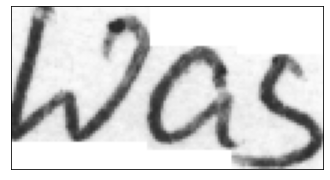

Label     : was
Prédiction:  was


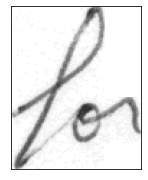

Label     : for
Prédiction:  for


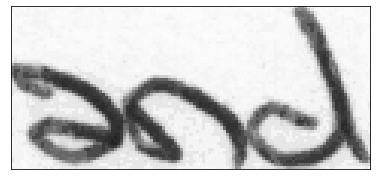

Label     : and
Prédiction:  and


In [7]:

# Création d'un dataset pour une image unique
def get_ds(img_path, encoded_label):
    x = np.array([img_path])
    y = np.array([encoded_label])
    ds = prepro.prepare_dataset_top10(x, y)
    return ds

def get_prediction(ds):
    inputs = []
    outputs = []
    for batch in ds:
        label_encode = batch[1] 
        #batch_images = tf.transpose(batch[0], [0,2,1,3])
        batch_images = batch[0]
        preds = model.predict(batch_images, verbose=0)
        #print(np.argmax(preds.tolist()[0]), label_encode)
        outputs += [np.argmax(v) for v in preds.tolist()]
        inputs += label_encode.numpy().tolist()
        #output += preds.tolist()
    return outputs, inputs


files = []
labels = []
predictions = []
distances = []
df_predict = df_test
for i in np.random.choice(np.arange(0, len(df_predict)), size=3):  
  label = df_predict.iloc[i].label
  encoded_label = df_predict.iloc[i].label_encoded
  img_path = df_predict.iloc[i].file
  ds = get_ds(img_path, encoded_label)
  prediction, inputs= get_prediction(ds)

  image = cv2.imread(img_path)
  plt.figure(figsize=(10,3))
  plt.imshow(image, cmap='gray')
  plt.xticks([])
  plt.yticks([])
  plt.show()
  print(f"Label     : {label}")
  #print("encoded label: ", encoded_label)
  #print("Input: ", inputs)
  print("Prédiction: ",encoder.inverse_transform(prediction)[0])


## Prédiction sur l'ensemble de test

In [8]:
ds = test_ds
outputs,inputs = get_prediction(ds)

        
df_result = pd.DataFrame({'file' : df_test.file,
                          'label': df_test.label,
                          'label_encoded' : df_test.label_encoded,
                          'prediction' : outputs,
                         })

df_result['label_decoded'] = encoder.inverse_transform(df_result['prediction'])
acc_test = df_result[df_result['label_encoded']==df_result["prediction"]].shape[0]/df_result.shape[0]
print("Accuracy sur l'ensemble de test :", acc_test)

df_result.drop("file", axis=1).head(20)

Accuracy sur l'ensemble de test : 0.9367088607594937


,label,label_encoded,prediction,label_decoded
91930,the,7,7,the
91940,not,5,5,not
91942,the,7,7,the
91946,the,7,7,the
91949,for,2,2,for
91961,was,8,8,was
91974,for,2,2,for
91976,the,7,7,the
91983,the,7,7,the
91987,was,8,8,was


## Metrics

Accuracy :  0.94
Classification report :
               precision    recall  f1-score   support

         The       0.97      0.93      0.95        30
         and       0.97      0.95      0.96       104
         for       0.93      0.93      0.93        28
         had       0.90      0.84      0.87        31
         his       0.96      0.74      0.84        35
         not       0.95      0.86      0.90        22
        that       0.92      0.94      0.93        51
         the       0.93      0.99      0.96       270
         was       0.95      0.85      0.90        41
        with       0.90      0.90      0.90        20

    accuracy                           0.94       632
   macro avg       0.94      0.89      0.91       632
weighted avg       0.94      0.94      0.94       632



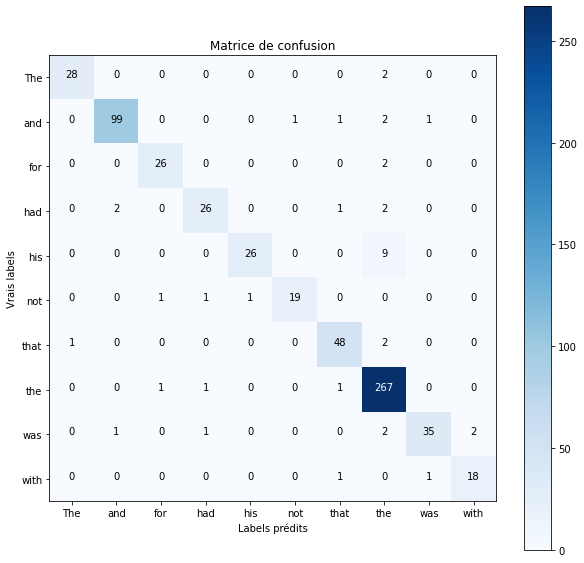

In [9]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import itertools

true_labels = df_result.label
pred_labels = df_result.label_decoded


print("Accuracy : ", round(accuracy_score(true_labels, pred_labels),2))
print("Classification report :\n", classification_report(true_labels, pred_labels))

cnf_matrix = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(10,10))
num_classes = 10
plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
plt.title("Matrice de confusion")
plt.colorbar()
tick_marks = np.arange(num_classes)
classes = encoder.inverse_transform(tick_marks)
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
             horizontalalignment = "center",
             color = "white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

plt.ylabel('Vrais labels')
plt.xlabel('Labels prédits')
plt.show()

for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    if(cnf_matrix[i,j] >15 and i!=j):
        print("Le mot '{0}' a souvent été pris pour le mot '{1}'".format(classes[i],classes[j]))